# Transformer

## Requirements

In [ ]:
pip install tensorflow_text

In [ ]:
pip install "numpy<2.0.0"

In [ ]:
pip install tensorflow_datasets

In [ ]:
pip install pandas

In [ ]:
pip install matplotlib

In [1]:
# import statements
import logging
import time
import numpy as np
import pandas as pd
import tensorflow_text
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import random
logging.getLogger('tensorflow').setLevel(logging.ERROR) # suppress warnings

## Load and preprocess the DataFrame

In [2]:
# read CSV file
df = pd.read_csv('/stopword_removal_dataframe.csv')

# display the first few rows of the dataframe
display(df)

,sentence1,sentence2,score,lang1,lang2,processed_language1,processed_language2
0,ein flugzeug hebt gerade ab,an air plane is taking off,5.0,de,en,Flugzeug heben,air plane
1,ein flugzeug hebt gerade ab,un avión está despegando,5.0,de,es,Flugzeug heben,avión despegar
2,ein flugzeug hebt gerade ab,un avion est en train de décoller,5.0,de,fr,Flugzeug heben,avion train décoller
3,ein flugzeug hebt gerade ab,un aereo sta decollando,5.0,de,it,Flugzeug heben,aereo stare decollare
4,ein flugzeug hebt gerade ab,飛行機が離陸します,5.0,de,ja,Flugzeug heben,飛行機 離陸
...,...,...,...,...,...,...,...
74737,un uomo sta tagliando i pomodori,uma mulher está a cortar brócolos,1.5,it,pt,stare tagliare pomodoro,mulher cortar brócolo
74738,un uomo sta tagliando i pomodori,женщина режет брокколи,1.5,it,ru,stare tagliare pomodoro,женщина режет брокколи
74739,un uomo sta tagliando i pomodori,一个女人正在切西兰花,1.5,it,zh,stare tagliare pomodoro,女人 切 西兰花
74740,男性がトマトを切っています,eine frau schneidet brokkoli,1.5,ja,de,男性 トマト 切る,Frau schneiden brokkoli


In [3]:
# I want to get the minimum and maximum for column 'score'
min_score = df['score'].min()
max_score = df['score'].max()
print(f"Minimum score: {min_score}")
print(f"Maximum score: {max_score}")

Minimum score: 0.0
Maximum score: 5.0


In [4]:
# Just to check if the values are actually between 0 and 1
df['normalized_score'] = df['score'] / 5.0
min_normalized_score = df['normalized_score'].min()
max_normalized_score = df['normalized_score'].max()
print(f"Minimum score: {min_normalized_score}")
print(f"Maximum score: {max_normalized_score}")

Minimum score: 0.0
Maximum score: 1.0


In [5]:
# # Convert the filtered dataframe to two lists
# input_texts = df['processed_language1'].tolist()
# target_texts = df['processed_language2'].tolist()

# print(type(input_texts), type(target_texts))         # should both be <class 'list'>
# print(type(input_texts[0]), type(target_texts[0]))   # should both be <class 'str'>

# # Ensure all elements in input_texts and target_texts are strings
# input_texts = [str(text) for text in input_texts]
# target_texts = [str(text) for text in target_texts]

# # Create the TensorFlow dataset
# dataset = tf.data.Dataset.from_tensor_slices((input_texts, target_texts))

# # Define split ratio
# split_ratio = 0.8
# total_size = len(input_texts)
# train_size = int(total_size * split_ratio)

# # Create train and validation datasets
# train_examples = dataset.take(train_size)
# val_examples = dataset.skip(train_size)

# train_examples = train_examples.repeat()

# here we are creating the train and val examples
examples = [
    {
        "sentence1": row['processed_language1'],
        "sentence2": row['processed_language2'],
        "score": row['normalized_score']
    }
    for _, row in df.iterrows()
]

random.shuffle(examples)

split_ratio = 0.8
split_index = int(len(examples) * split_ratio)

train_examples = examples[:split_index]
val_examples = examples[split_index:]



In [6]:
# Let's check if both are in the right format
print(train_examples[0])
print(val_examples[0])

{'sentence1': '誰 恩 物 混ぜる', 'sentence2': 'quelquun train coudre chose', 'score': 0.05}
{'sentence1': 'arbre courber tempête', 'sentence2': 'drzewo uderzać silny wiatr', 'score': 0.5334}


## Build tokenizer

In [7]:
# # Build tokenizers from my text
# input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
#     (text for text in input_texts), target_vocab_size=2**13)

# target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
#     (text for text in target_texts), target_vocab_size=2**13)

# Combine both sides of the pairs for a shared vocabulary
all_sentences = pd.concat([df['processed_language1'], df['processed_language2']]).astype(str)

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (text for text in all_sentences), target_vocab_size=2**13)


In [ ]:
tokenizer.save_to_file('/Users/dionnespaltman/Desktop/Luiss/Machine Learning/Project/tokenizer_input')

# Helper functions

In [8]:
# # Function to tokenize input-target pairs
# # So it gets the input string and the target string and returns tokenized version
# def encode_pair(input_str, target_str):
#     input_tokens = input_tokenizer.encode(input_str.numpy().decode('utf-8'))
#     target_tokens = target_tokenizer.encode(target_str.numpy().decode('utf-8'))
#     return input_tokens, target_tokens

def encode_pair(sentence1, sentence2, score):
    tokens1 = tokenizer.encode(sentence1.numpy().decode('utf-8'))
    tokens2 = tokenizer.encode(sentence2.numpy().decode('utf-8'))
    return tokens1, tokens2, score

# def tf_encode(input_str, target_str):
#     input_tokens, target_tokens = tf.py_function(encode_pair, [input_str, target_str], [tf.int64, tf.int64])
#     return input_tokens, target_tokens

# Wrap with tf.py_function to use in TensorFlow pipeline
# This lets you use regular Python code (like calling .numpy() and .decode()) inside a TensorFlow data pipeline
def tf_encode(sentence1, sentence2, score):
    tokens1, tokens2, score = tf.py_function(
        encode_pair, [sentence1, sentence2, score], [tf.int64, tf.int64, tf.float32]
    )
    tokens1.set_shape([None])
    tokens2.set_shape([None])
    score.set_shape([])  # scalar float
    return tokens1, tokens2, score

# # Map the datasets through the tokenizer
# # It applies tf_encode to every pair in the dataset. Now each example in train_dataset is a pair of tokenized sequences
# train_dataset = train_examples.map(tf_encode)
# val_dataset = val_examples.map(tf_encode)


# Make batches

A batch is a group of training examples processed together in one forward/backward pass, which speeds up training and stabilizes gradients.

In NLP, each batch contains tokenized and padded sentence pairs (plus labels like similarity scores) arranged as tensors of equal shape.


In [9]:
MAX_SEQ_LEN = 128

def encode_pair_fixed(input_str, target_str):
    input_tokens = tokenizer.encode(input_str.numpy().decode('utf-8'))[:MAX_SEQ_LEN]
    target_tokens = tokenizer.encode(target_str.numpy().decode('utf-8'))[:MAX_SEQ_LEN]

    # Pad manually
    input_tokens += [0] * (MAX_SEQ_LEN - len(input_tokens))
    target_tokens += [0] * (MAX_SEQ_LEN - len(target_tokens))

    return input_tokens, target_tokens

def tf_encode(input_str, target_str, score):
    input_tokens, target_tokens = tf.py_function(
        encode_pair_fixed, [input_str, target_str], [tf.int64, tf.int64]
    )
    input_tokens.set_shape([MAX_SEQ_LEN])
    target_tokens.set_shape([MAX_SEQ_LEN])
    return input_tokens, target_tokens, score


def make_batches(examples, batch_size=32):
    sent1_list = []
    sent2_list = []
    score_list = []

    for ex in examples:
        try:
            s1 = str(ex["sentence1"])
            s2 = str(ex["sentence2"])
            score = float(ex["score"])
            sent1_list.append(s1)
            sent2_list.append(s2)
            score_list.append(score)
        except Exception as e:
            print("Skipping example due to error:", ex, e)
            continue

    sent1_tensor = tf.constant(sent1_list)
    sent2_tensor = tf.constant(sent2_list)
    score_tensor = tf.constant(score_list, dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((sent1_tensor, sent2_tensor, score_tensor))
    dataset = dataset.map(tf_encode, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.padded_batch(batch_size, padded_shapes=([None], [None], []))
    # MAX_SEQ_LEN = 128
    # dataset = dataset.padded_batch(batch_size, padded_shapes=([MAX_SEQ_LEN], [MAX_SEQ_LEN], []))
    dataset = dataset.batch(batch_size)
    # dataset = dataset.repeat()  # Infinite dataset
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # return dataset, sent1_list, sent2_list

    return dataset



In [10]:
train_batches = make_batches(train_examples)

# Inspect a single batch
for sent1, sent2, score in train_batches.take(1):
    print("Shape sent1:", sent1.shape)
    print("Shape sent2:", sent2.shape)
    print("Shape score:", score.shape)

    # Check if all shapes in the batch are as expected
    assert sent1.shape[1] == MAX_SEQ_LEN, f"sent1 sequence length mismatch: {sent1.shape[1]}"
    assert sent2.shape[1] == MAX_SEQ_LEN, f"sent2 sequence length mismatch: {sent2.shape[1]}"
    assert sent1.shape == sent2.shape, f"Mismatch between sent1 and sent2: {sent1.shape} vs {sent2.shape}"


Shape sent1: (32, 128)
Shape sent2: (32, 128)
Shape score: (32,)


In [11]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)


## Get everything ready

- Prepare tokenized, batched, and masked data for input into a Transformer model.
- Implement core components of the Transformer: positional encoding and multi-head attention.
- This sits between raw data preprocessing and full model definition.

In [12]:
print("Sample types in sent1_list:", {type(s) for s in sent1_list})
print("Sample types in sent2_list:", {type(s) for s in sent2_list})


NameError: name 'sent1_list' is not defined

In [13]:
# DATASET PREPARATION

# Define constants for dataset preparation
# MAX_TOKENS = 128
# BUFFER_SIZE = 20000  # Size of the buffer for shuffling the dataset.
# BATCH_SIZE = 64  # Number of samples per batch.

# Lower constants for baseline
MAX_TOKENS = 128
BUFFER_SIZE = 1000  # Size of the buffer for shuffling the dataset.
BATCH_SIZE = 16  # Number of samples per batch.

# Tokenization function
def tokenize_pairs(input_text, target_text):
    """
    Tokenizes both input and target strings using SubwordTextEncoder-like tokenizers.
    Returns int64 token sequences with shape info attached.
    """
    # Encode using SubwordTextEncoder and convert to padded tensors
    input_tokens = tf.py_function(
        lambda x: tf.constant(tokenizer.encode(x.numpy().decode('utf-8')), dtype=tf.int64),
        [input_text],
        tf.int64
    )
    target_tokens = tf.py_function(
        lambda x: tf.constant(tokenizer.encode(x.numpy().decode('utf-8')), dtype=tf.int64),
        [target_text],
        tf.int64
    )

    # Help TF understand the rank of returned tensors for later batching
    input_tokens.set_shape([None])
    target_tokens.set_shape([None])
    return input_tokens, target_tokens

# Filtering function to exclude long sequences
def filter_max_tokens(input_tensor, target_tensor):
    """
    Filters out input-target pairs where either sequence exceeds MAX_TOKENS.
    """
    num_tokens = tf.maximum(tf.shape(input_tensor)[0], tf.shape(target_tensor)[0])
    return num_tokens < MAX_TOKENS

# # Batching and preprocessing wrapper
# def make_batches(ds):
#     """
#     Caches, shuffles, tokenizes, filters, pads, and batches the dataset.
#     """
#     return (
#         ds
#         .cache()
#         .shuffle(BUFFER_SIZE)
#         .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
#         .filter(filter_max_tokens)
#         .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))  # pad manually here
#         # .repeat() # NEW ADDITION
#         .prefetch(tf.data.AUTOTUNE)
#     )


# Prepare the training and validation datasets by applying the make_batches function.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)


In [14]:
# Take a small batch (e.g., 3) from the batched and tokenized dataset
for sent1_batch, sent2_batch, score_batch in train_batches.take(1):
    print("> Sentence 1 Examples:")
    for line in sent1_batch.numpy():
        print(tokenizer.decode([token for token in line if token != 0]))

    print("----------------------------------------------")

    print("> Sentence 2 Examples:")
    for line in sent2_batch.numpy():
        print(tokenizer.decode([token for token in line if token != 0]))

    print("----------------------------------------------")

    print("> Similarity Scores:")
    print(score_batch.numpy())

    print("----------------------------------------------")

    print("> Token IDs (Sentence 1):")
    for line in sent1_batch.numpy():
        print(line)

    print("----------------------------------------------")

    print("> Token IDs (Sentence 2):")
    for line in sent2_batch.numpy():
        print(line)

# # Take a small batch (e.g., 3) from the dataset
# for src_examples, tgt_examples in train_examples.batch(3).take(1):
#     print("> Examples in Source Language:")
#     for line in src_examples.numpy():
#         print(line.decode('utf-8'))

# print("----------------------------------------------")

# print("> Examples in Target Language:")
# for line in tgt_examples.numpy():
#     print(line.decode('utf-8'))

# print("----------------------------------------------")

# # Tokenize the target examples using your custom tokenizer
# encoded = [tokenizer.encode(text.numpy().decode('utf-8')) for text in tgt_examples]

# # Print tokenized form
# for row in encoded:
#     print(row)

# print("----------------------------------------------")

> Sentence 1 Examples:
誰 恩 物 混ぜる
rapaz tocar tecladomudo
носорог пасся трава
Mann spielen flöte
persona stare preparare letto
チンパンジー 女性 傷つける
ктото режет тортилу
jung spielen Gitarre
femme ajout épice viande
twee man dansen
女性 レモン 絞る
homme dun tshirt you tube gris
chef limpar tigela sopa
man sit chair stare
食堂 男 女 話す
człowiek umierać sala operacyjny
femme coup citron
man vissen
señora bebé cubo basura
shirtless man sit chair
fußballspiel kicken Fußball Tor
suonare pianoforte
chłopak jechać trójkołowy rower
女性 ボウル 卵 2 入れる 叩く
persona stare affettare pomodoro
Mann steigen Auto
человек играть пианино
カンガルー 抱く 女性
男 腕立て 伏せ
man play guitar
человек чистить яблоко
man liggen grond richten geweer
----------------------------------------------
> Sentence 2 Examples:
quelquun train coudre chose
男の子 ピアノ 弾く
nosorożec pasie pole
человек играть флейта
persona comer mesa
man rijden auto
quelquun mont cheval
hombre tocar guitarra
женщина добавлять сахар мясо
二人 女性 買い物
Frau drücken Saft Zitrone
homem most

In [15]:
# POSITIONAL ENCODING
# Transformers have no recurrence or convolution, so we inject sequence order using sine/cosine signals.

def get_angles(pos, i, d_model):
    """
    Computes the angle rates for the positional encoding.
    The formula ensures that each dimension of the embedding varies at a different wavelength (some change faster than others).

    Parameters:
    - pos: Position index.
    - i: Dimension index.
    - d_model: Depth of the model (number of dimensions).

    Returns:
    - The angle rates for positional encoding.
    """
    # Calculate the angles based on position and dimension index.
    # This formula helps in varying the wavelength across different dimensions.
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    """
    Generates a positional encoding matrix.

    Parameters:
    - position: The maximum position index.
    - d_model: The depth of the model (number of dimensions).

    Returns:
    - A positional encoding matrix of shape (1, position, d_model).
    """
    # Generate angles based on positions and dimensions.
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # Apply sine to even indices in the angles array (2i).
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # Apply cosine to odd indices in the angles array (2i+1).
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # Expand the dimensions to fit the model requirements.
    pos_encoding = angle_rads[np.newaxis, ...]
    # Cast the encoding to TensorFlow float32 type.
    return tf.cast(pos_encoding, dtype=tf.float32)


In [16]:
# MASKING
# Masks prevent attention to padding tokens or future tokens during decoding.

def create_padding_mask(seq):
    """
    Creates a padding mask for sequences.
    This mask hides the padding tokens (i.e., zeros) so they don't affect the attention mechanism. It returns 1s where padding exists, and 0s elsewhere.
    Parameters:
    - seq: The sequence of tokens.

    Returns:
    - A padding mask for the sequence.
    """
    # Create a mask where every zero in the sequence is marked with a 1 (padding) and others with a 0.
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Add extra dimensions to the mask so it can be added to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    """
    Creates a look-ahead mask to mask future tokens in a sequence.
    Each token can only see previous ones (or itself), but not the next ones, ensuring proper autoregressive behavior.
    Parameters:
    - size: Size of the mask.

    Returns:
    - A look-ahead mask of shape (size, size).
    """
    # Create a mask where every entry that is in the lower triangle (including the diagonal) is 0, and everything else is 1.
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # Shape: (seq_len, seq_len)


In [17]:
# SCALING AND DOT PRODUCT ATTENTION
# This is the core building block of attention: compare queries with keys, weigh values

def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Calculates the attention weights and applies them to the value vectors.

    Parameters:
    - q (query): Tensor with shape (..., seq_len_q, depth)
    - k (key): Tensor with shape (..., seq_len_k, depth)
    - v (value): Tensor with shape (..., seq_len_v, depth_v)
    - mask: (Optional) Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k).

    Returns:
    - output: The result of applying attention weights to the value vectors.
    - attention_weights: The attention weights.
    """
    # Compute the dot product of the query and key tensors. Transpose the key tensor for proper alignment.
    # This gives us a similarity score between each query and key.
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # Shape: (..., seq_len_q, seq_len_k)

    # Scale the dot product by the square root of the depth of the key tensor.
    # This helps in preventing the softmax function from having extremely small gradients.
    dk = tf.cast(tf.shape(k)[-1], tf.float32)  # Get the depth of the keys.
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Apply the mask if provided. The mask is used to nullify the effect of padding or future information.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # Use a large negative number to mask.

    # Apply softmax to get the attention weights. The softmax is applied on the key sequence dimension.
    # It shows how much attention each word pays to others.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # Shape: (..., seq_len_q, seq_len_k)

    # Apply the attention weights to the value tensor to get the output.
    output = tf.matmul(attention_weights, v)  # Shape: (..., seq_len_q, depth_v)

    return output, attention_weights



In [18]:
# MULTIHEAD ATTENTION
# Instead of attending once, we split into multiple attention "heads" for richer representations

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads):
        """
        Initialize the MultiHeadAttention layer.

        Parameters:
        - d_model: Dimensionality of the model's output space.
        - num_heads: Number of attention heads.
        """
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # Number of attention heads.
        self.d_model = d_model  # Dimensionality of the model's output space.

        # Ensure the model's dimension is divisible by the number of heads to evenly distribute dimensions to each head.
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads  # Dimensionality per attention head.

        # Define dense layers for the queries, keys, and values.
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        # Final dense layer.
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth) and transpose the result.

        Parameters:
        - x: Input tensor.
        - batch_size: Size of the batch.

        Returns:
        - Tensor with shape (batch_size, num_heads, seq_len, depth).
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        """
        The logic for the multi-head attention layer's forward pass.

        Parameters:
        - v: Value tensor.
        - k: Key tensor.
        - q: Query tensor.
        - mask: Mask to be applied.

        Returns:
        - output: Output tensor.
        - attention_weights: Attention weights.
        """
        batch_size = tf.shape(q)[0]

        # Apply dense layers to queries, keys, and values.
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # Split the dense outputs into multiple heads and transpose.
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # Perform scaled dot product attention.
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        # Transpose and reshape the attention output to match the input's dimensionality.
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # Apply the final dense layer.
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights


In [19]:
def point_wise_feed_forward_network(d_model, dff):
    """
    Creates a point-wise feed forward network. This consists of two dense layers with a ReLU activation
    in between, which is used within each transformer block.

    Parameters:
    - d_model: The dimensionality of the input and output of the transformer model.
    - dff: The dimensionality of the inner layer, typically much larger than d_model to allow
           the model to combine features in the data in a high-dimensional space before projecting
           back down to d_model dimensions.

    Returns:
    - A tf.keras.Sequential model representing the feed forward network.
    """
    return tf.keras.Sequential([
        # First dense layer with dff units and ReLU activation. This expands the dimensionality to dff,
        # allowing the network to learn more complex features.
        tf.keras.layers.Dense(dff, activation='relu'),  # Output shape: (batch_size, seq_len, dff)

        # Second dense layer that projects the outputs back down to d_model dimensions.
        tf.keras.layers.Dense(d_model)  # Output shape: (batch_size, seq_len, d_model)
    ])

## Encoder layer
We're now implementing the core building block of the Transformer encoder — the EncoderLayer. This is one layer in the stacked encoder block of the Transformer architecture.

High-Level Role of EncoderLayer is:
- Each encoder layer transforms an input sequence into a richer representation, by letting each token attend to all others (via self-attention);
- Then refining that with a feed-forward network;
- You’ll stack multiple of these layers to form the full encoder (e.g., num_layers = 6).


The EncoderLayer **combines**:

* Multi-Head Self-Attention

* Feed Forward Network

* Layer Normalization

* Dropout

* Residual Connections

Each EncoderLayer **learns** to:

* Focus on different parts of the input through self-attention.

* Extract features and relationships (such as distances) between words.

* Stabilize training using layer normalization and residual connections.*κείμενο σε πλάγια γραφή*

In [20]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, rate=0.1):
        """
        Initializes the EncoderLayer with multi-head attention, point-wise feed-forward network,
        dropout, and layer normalization components.

        Parameters:
        - d_model: Dimensionality of the model's output space.
        - num_heads: Number of attention heads.
        - dff: Dimensionality of the feed-forward network's inner layer.
        - rate: Dropout rate.
        """
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)  # Multi-head attention layer.
        self.ffn = point_wise_feed_forward_network(d_model, dff)  # Point-wise feed-forward network.

        # Layer normalization (first instance).
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Layer normalization (second instance).
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout (first instance).
        self.dropout1 = tf.keras.layers.Dropout(rate)
        # Dropout (second instance).
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        """
        The logic for one pass of the encoder layer.

        Parameters:
        - x: Input tensor.
        - training: Boolean indicating if the layer should behave in training mode (applying dropout) or in inference mode.
        - mask: Mask to be applied on the multi-head attention layer.

        Returns:
        - The output tensor of the encoder layer.
        """
        # Apply multi-head attention to the input (self attention).
        attn_output, _ = self.mha(x, x, x, mask)  # Output shape: (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)  # Apply dropout to the attention output.

        # Add & normalize.
        out1 = self.layernorm1(x + attn_output)  # Residual connection followed by layer normalization.

        # Apply the feed-forward network to the normalized attention output.
        ffn_output = self.ffn(out1)  # Output shape: (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)  # Apply dropout to the feed-forward network output.

        # Final add & normalize step.
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection followed by another layer normalization.

        return out2

## Encoder

In [21]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        """
        Initializes the Encoder part of the Transformer.

        Parameters:
        - num_layers: Number of encoder layers.
        - d_model: Dimensionality of the model's output space.
        - num_heads: Number of attention heads.
        - dff: Dimensionality of the feed-forward network's inner layer.
        - input_vocab_size: Size of the input vocabulary.
        - rate: Dropout rate.
        """
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding layer for the input tokens.
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)

        # Positional encoding up to MAX_TOKENS.
        self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

        # Encoder layers
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]

        # Dropout layer.
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # Adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Scale embeddings.
        x += self.pos_encoding[:, :seq_len, :]  # Add position encoding.
        x = self.dropout(x, training=training)  # Apply dropout.

        # Pass the input through each encoder layer.
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)


        return x  # (batch_size, input_seq_len, d_model)

## Transformer

In [22]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        """
        Initializes the Transformer model for sentence similarity.
        """
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, input_vocab_size=input_vocab_size, rate=rate)

        # # Final linear layer that projects the decoder's output to the target vocabulary size.
        # self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        """
        The logic for one forward pass through the model.

        Parameters:
        - inputs: A tuple of input tensor and target tensor.
        - training: Boolean indicating if the layer should behave in training mode or inference mode.

        Returns:
        - sentence_embedding: A fixed-size vector representation (e.g., mean-pooled encoder output).
        """
        # Create encoder padding mask
        enc_padding_mask = create_padding_mask(inputs)

        # Run encoder
        enc_output = self.encoder(inputs, training=training, mask=enc_padding_mask)  # (batch_size, seq_len, d_model)

        # Reduce to fixed-size vector (e.g., mean pooling)
        sentence_embedding = tf.reduce_mean(enc_output, axis=1)  # (batch_size, d_model)
        return sentence_embedding

        # inp, tar = inputs

        # # Create masks for padding and future tokens.
        # enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        # # Pass the input through the encoder.
        # #enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        # #self.encoder(inp, training=training, mask=enc_padding_mask)
        # enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)

        # # Pass the encoder output and target through the decoder.
        # #dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        # #self.decoder(tar, enc_output, training=training,
        #  #    look_ahead_mask=look_ahead_mask,
        #   #   padding_mask=dec_padding_mask)

        # dec_output, attention_weights = self.decoder(
        #       tar,
        #       enc_output,
        #       training=training,
        #       look_ahead_mask=look_ahead_mask,
        #       padding_mask=dec_padding_mask)


        # # Pass the decoder output through the final linear layer.
        # final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        # return final_output, attention_weights


    # def create_masks(self, inp, tar):
    #     """
    #     Creates masks for padding and look ahead for the encoder and decoder.

    #     Parameters:
    #     - inp: Input tensor.
    #     - tar: Target tensor.

    #     Returns:
    #     - enc_padding_mask: Padding mask for the encoder.
    #     - look_ahead_mask: Look-ahead mask for the decoder.
    #     - dec_padding_mask: Padding mask for the decoder to mask the encoder outputs.
    #     """
    #     # Encoder padding mask.
    #     enc_padding_mask = create_padding_mask(inp)

    #     # Decoder padding mask for the second attention block (to mask encoder outputs).
    #     dec_padding_mask = create_padding_mask(inp)

    #     # Look-ahead mask (to mask future tokens) and decoder target padding mask combined.
    #     look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    #     dec_target_padding_mask = create_padding_mask(tar)
    #     look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    #     return enc_padding_mask, look_ahead_mask, dec_padding_mask

# -------------------------------
# Transformer Model Hyperparameters
# -------------------------------

num_layers = 4 # number of encoder/decoder layers in the Transformer
d_model = 128 # size of the embedding vector for each word
dff = 512 # size of the hidden layer inside the Feed Forward Neural Network
num_heads = 8 # number of attention heads (must divide d_model evenly)
dropout_rate = 0.1 # dropout rate for regularization

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Model dimensionality, cast to float32 for calculation.
        self.warmup_steps = warmup_steps  # Number of steps to linearly increase the learning rate.

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)  # Linearly increase then decrease based on warmup steps.
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)  # Calculate the learning rate.
        # Final learning rate: (1 / sqrt(d_model)) * min(arg1, arg2)

# Instantiate the learning rate schedule and Adam optimizer
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,         # First moment decay (default)
    beta_2=0.98,        # Second moment decay (used in the original Transformer paper)
    epsilon=1e-9        # Small value to avoid division by zero
)

# def loss_function(real, pred):
#     mask = tf.math.logical_not(tf.math.equal(real, 0))  # Create a mask for non-zero tokens.
#     loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
#     loss_ = loss_object(real, pred)  # Calculate loss using some loss object not defined here.
#     mask = tf.cast(mask, dtype=loss_.dtype)  # Cast mask to the same type as the loss.
#     loss_ *= mask  # Apply mask to the loss.
#     return tf.reduce_sum(loss_) / tf.reduce_sum(mask)  # Calculate the average loss.

# def accuracy_function(real, pred):
#     accuracies = tf.equal(real, tf.argmax(pred, axis=2))  # Check if real values match predictions.
#     mask = tf.math.logical_not(tf.math.equal(real, 0))  # Create a mask for non-zero tokens.
#     accuracies = tf.math.logical_and(mask, accuracies)  # Apply mask to accuracies.
#     accuracies = tf.cast(accuracies, dtype=tf.float32)  # Cast to float32 for calculation.
#     mask = tf.cast(mask, dtype=tf.float32)  # Cast mask to float32.
#     return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)  # Calculate the average accuracy.

# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# Similiarity Model

In [23]:
class SimilarityModel(tf.keras.Model):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Output similarity score between 0 and 1
        ])

    def call(self, inputs, training=False):
        sent1, sent2 = inputs  # each: (batch_size, seq_len)

        embed1 = self.transformer(sent1, training=training)  # (batch_size, d_model)
        embed2 = self.transformer(sent2, training=training)  # (batch_size, d_model)

        # Combine embeddings (common in sentence similarity tasks)
        combined = tf.concat([
            embed1,
            embed2,
            tf.abs(embed1 - embed2),
            embed1 * embed2
        ], axis=1)  # (batch_size, 4 * d_model)

        return self.dense(combined)  # (batch_size, 1)


In [24]:
# -------------------------------
# Instantiate the Transformer model
# -------------------------------
transformer = Transformer(
    num_layers=num_layers,                        # Number of encoder and decoder layers
    d_model=d_model,                              # Embedding size / model dimensionality
    num_heads=num_heads,                          # Number of attention heads
    dff=dff,                                      # Hidden layer size in feed-forward network
    input_vocab_size = tokenizer.vocab_size,
    # target_vocab_size = target_tokenizer.vocab_size,
    rate=dropout_rate                             # Dropout rate
)

# -------------------------------
# Checkpointing: Saving and restoring model state
# -------------------------------

checkpoint_path = './checkpoints/train'   # Directory to save training checkpoints

# Create a checkpoint object that tracks the transformer and optimizer state
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

# Manage multiple checkpoints (e.g., keep the 5 latest ones)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a previous checkpoint exists, restore the model and optimizer state
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# -------------------------------
# Define input signature for tf.function (for performance optimization)
# Used to decorate the training step function later
# -------------------------------
# train_step_signature = [
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # Input sequence shape: (batch_size, input_seq_len)
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # Target sequence shape: (batch_size, target_seq_len)
# ]

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # sentence1
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # sentence2
    tf.TensorSpec(shape=(None,), dtype=tf.float32),     # similarity label (e.g., 0.0 to 1.0)
]

# -------------------------------
# Instantiate the Sentence similarity model
# -------------------------------
similarity_model = SimilarityModel(transformer)

# Initiate loss function and metrics
loss_fn = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.Mean(name="train_loss")


## Baseline



In [25]:
# DEBUG: Peek at one batch from train_batches
print("Inspecting batch structure...")
train_batches = make_batches(train_examples)
train_iter = iter(train_batches)

first = next(train_iter)

print("Raw output of next(train_iter):", type(first))
print("Length of output:", len(first))

# Try printing all contents in the batch
for i, item in enumerate(first):
    print(f"\nElement {i}:")
    print("  Type:", type(item))
    print("  Shape:", item.shape)
    print("  DType:", item.dtype)
    print("  Example values:", item.numpy()[:1])


Inspecting batch structure...
Raw output of next(train_iter): <class 'tuple'>
Length of output: 3

Element 0:
  Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Shape: (32, 128)
  DType: <dtype: 'int64'>
  Example values: [[ 173 2309 8390 1741  999    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]

Element 1:
  Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Shape: (32, 128)
  DType: <

In [26]:
@tf.function(input_signature=train_step_signature)
def train_step(sent1, sent2, score):
    """
    Performs a single training step for the similarity model.

    Args:
    - sent1: Tokenized first sentence (batch_size, seq_len)
    - sent2: Tokenized second sentence (batch_size, seq_len)
    - score: Continuous similarity score (batch_size,)

    Returns:
    - loss: Scalar MSE loss
    - pred: Predicted similarity score
    """
    with tf.GradientTape() as tape:
        pred = similarity_model((sent1, sent2), training=True)
        pred = tf.squeeze(pred, axis=1)  # (batch_size,)
        loss = loss_fn(score, pred)

    gradients = tape.gradient(loss, similarity_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, similarity_model.trainable_variables))
    train_loss.update_state(loss)

    return loss, pred

    # # Prepare target inputs and outputs
    # tar_inp = tar[:, :-1]
    # tar_real = tar[:, 1:]

    # with tf.GradientTape() as tape:
    #     predictions, _ = transformer([inp, tar_inp], training=True)
    #     loss = loss_function(tar_real, predictions)

    # # Compute gradients and apply them
    # gradients = tape.gradient(loss, transformer.trainable_variables)
    # optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # # Update the training loss and accuracy metrics
    # train_loss(loss)
    # train_accuracy(accuracy_function(tar_real, predictions))

    # return loss, predictions

# epoch_accuracies = []
# all_batch_accuracies = []

EPOCHS = 10
steps_per_epoch = len(train_examples) // BATCH_SIZE
# steps_per_epoch = 1000  # Set based on dataset size / batch size

epoch_losses = []
all_batch_losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1} -------------------")
    # print("Re-initializing dataset iterator")

    # Reset metrics
    train_loss = tf.keras.metrics.Mean(name='train_loss')

    train_batches = make_batches(train_examples)  # Must return (sent1, sent2, score)
    train_iter = iter(train_batches)

    batch_losses = []
    start = time.time()

    # # Peek at 1 batch
    # try:
    #     sample = next(train_iter)
    #     print("Batch loaded successfully.")
    # except Exception as e:
    #     print("Batch loading failed:", e)


    # # Recreate infinite train_batches with .repeat()
    # train_batches = make_batches(train_examples)
    # train_iter = iter(train_batches)

    # batch_accuracies = []

    # # Reset metrics
    # train_loss = tf.keras.metrics.Mean(name='train_loss')
    # train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

    # Use fixed number of steps instead of iterating over the whole dataset
    for step in range(steps_per_epoch):
        # inp, tar = next(train_iter)
        try:
            # (batch,) = next(train_iter)  # Unpack the tuple
            # sent1, sent2, score = batch
            sent1, sent2, score = next(train_iter)


        except StopIteration:
            # If the iterator is exhausted, recreate it
            # train_iter = iter(train_batches)
            # (batch,) = next(train_iter)
            # sent1, sent2, score = batch

            train_iter = iter(train_batches)
            sent1, sent2, score = next(train_iter)



        # loss, predictions = train_step(inp, tar)
        loss, _ = train_step(sent1, sent2, score)

        batch_losses.append(loss.numpy())

        # batch_accuracies.append(accuracy_function(tar[:, 1:], predictions).numpy())

        # if step % 50 == 0:
        #     print(f'Epoch {epoch + 1} Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if step % 50 == 0:
            print(f'Epoch {epoch + 1} Step {step} Loss {train_loss.result():.4f}')


    all_batch_losses.append(batch_losses)
    epoch_losses.append(train_loss.result().numpy())
    # all_batch_accuracies.append(batch_accuracies)

    # epoch_accuracies.append(train_accuracy.result().numpy())

    if (epoch + 1) % 3 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    # print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    # print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')



Epoch 1 -------------------
Epoch 1 Step 0 Loss 0.2150
Epoch 1 Step 50 Loss 0.1204
Epoch 1 Step 100 Loss 0.1146
Epoch 1 Step 150 Loss 0.1114
Epoch 1 Step 200 Loss nan
Epoch 1 Step 250 Loss nan
Epoch 1 Step 300 Loss nan
Epoch 1 Step 350 Loss nan
Epoch 1 Step 400 Loss nan
Epoch 1 Step 450 Loss nan
Epoch 1 Step 500 Loss nan
Epoch 1 Step 550 Loss nan
Epoch 1 Step 600 Loss nan
Epoch 1 Step 650 Loss nan
Epoch 1 Step 700 Loss nan
Epoch 1 Step 750 Loss nan
Epoch 1 Step 800 Loss nan
Epoch 1 Step 850 Loss nan
Epoch 1 Step 900 Loss nan
Epoch 1 Step 950 Loss nan
Epoch 1 Step 1000 Loss nan
Epoch 1 Step 1050 Loss nan
Epoch 1 Step 1100 Loss nan
Epoch 1 Step 1150 Loss nan
Epoch 1 Step 1200 Loss nan
Epoch 1 Step 1250 Loss nan
Epoch 1 Step 1300 Loss nan
Epoch 1 Step 1350 Loss nan
Epoch 1 Step 1400 Loss nan
Epoch 1 Step 1450 Loss nan
Epoch 1 Step 1500 Loss nan
Epoch 1 Step 1550 Loss nan
Epoch 1 Step 1600 Loss nan
Epoch 1 Step 1650 Loss nan
Epoch 1 Step 1700 Loss nan
Epoch 1 Step 1750 Loss nan
Epoch 1 St

# Evaluate

In [27]:
# Evaluate on the validation set

val_loss = tf.keras.metrics.Mean(name="val_loss")

for sent1_val, sent2_val, score_val in val_batches:
    pred_val = similarity_model((sent1_val, sent2_val), training=False)
    pred_val = tf.squeeze(pred_val, axis=1)
    loss = loss_fn(score_val, pred_val)
    val_loss.update_state(loss)

print(f"Validation Loss (MSE): {val_loss.result().numpy():.4f}")



Validation Loss (MSE): nan


In [33]:
# Save
#similarity_model.save_weights("transformer_similarity_weights.h5")

# Later, to load them back:
# similarity_model.load_weights("transformer_similarity_weights.h5")


# Plot

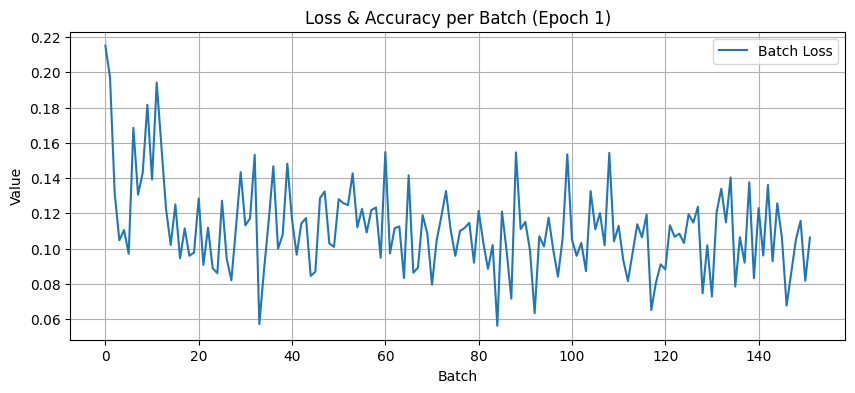

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(all_batch_losses[0], label='Batch Loss')
#plt.plot(all_batch_accuracies[0], label='Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.title('Loss & Accuracy per Batch (Epoch 1)')
plt.legend()
plt.grid(True)
plt.show()
